In [35]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import sklearn
from xgboost import XGBRegressor
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import f1_score
from sklearn.cluster import KMeans
import joblib
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

In [36]:
root_dir = "dataset2/"
N=10
L = 1200 # number of sample is each window. 400 = 20s @ 20hz
novel_id = 2 # id of the state that will be treated as novel

x_nominal_list = []
x_novel_list = []

for i in range(N):
    if i == 5:
        continue
    trace = np.load(root_dir+f"trace_{str(i).zfill(2)}.npy")
    gt = np.load(root_dir+f"gt_{str(i).zfill(2)}.npy").astype('int')
    
    for i in np.arange(0,trace.shape[0],L)[:-1]: # remove the last index because it generates a window too small (end of trace)
        window = trace[i:i+L].reshape(1,-1)
        
        # add window to either list depending if it contains novel sample
        if novel_id in gt[i:i+L]:
            x_novel_list.append(window)
        else:
            x_nominal_list.append(window) 

X_nominal = np.concatenate(x_nominal_list, axis=0)
X_novel = np.concatenate(x_novel_list, axis=0)

# shuffle the samples in place
np.random.shuffle(X_nominal)
np.random.shuffle(X_novel)

print(f"Shape of nominal (training) dataset: {X_nominal.shape[0]} snippets of {X_nominal.shape[1]} samples")
print(f"Shape of novel (test) dataset:        {X_novel.shape[0]} snippets of {X_novel.shape[1]} samples")

Shape of nominal (training) dataset: 1874 snippets of 1200 samples
Shape of novel (test) dataset:        285 snippets of 1200 samples


array([[ 4620.5,  5381. ,  4127. , ...,  3922. ,  3932.5,  3941.5],
       [13845.5, 13893. , 13823. , ..., 13930. , 13934.5, 13917.5],
       [13946. , 13941.5, 13948.5, ..., 13985. , 13930. , 13997.5],
       ...,
       [13681.5, 13749.5, 13763. , ..., 13746.5, 13713. , 13774. ],
       [ 4401. ,  4368.5,  4410. , ...,  3950.5,  3952.5,  3956. ],
       [13953. , 13977. , 13948.5, ..., 13940. , 13950. , 13958. ]])

In [ ]:
trace = np.append(np.load("dataset/trace_0.npy"),np.load("dataset/trace_3.npy"))
gt = np.append(np.load("dataset/gt_0.npy"),np.load("dataset/gt_2.npy"))

In [164]:
## NOT GOOD
## 11, 12 13 ,15- wierd
## 14 - no high load



In [176]:
trace = np.load("dataset2/trace_15.npy")
gt = np.load("dataset2/gt_14.npy")

In [178]:
pd.DataFrame(gt).value_counts()

1.0    191469
0.0     48300
2.0     48000
3.0       442
Name: count, dtype: int64

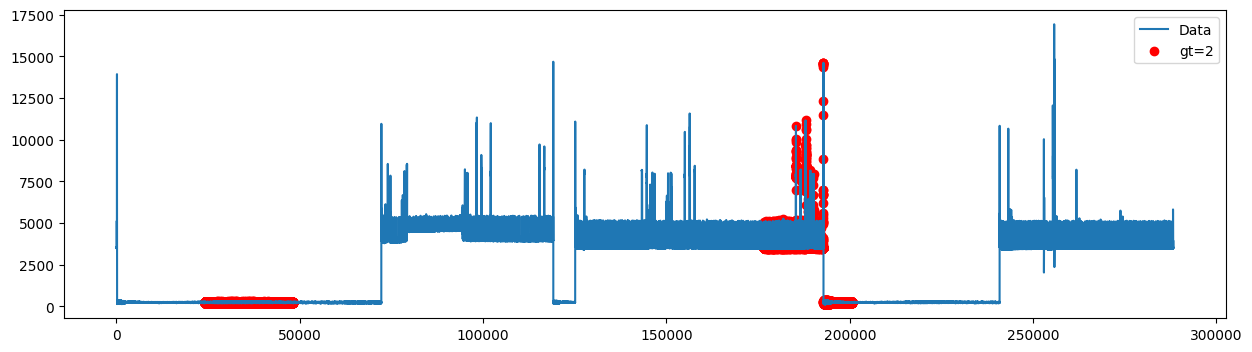

In [179]:
trace_array = np.array(trace)
gt_array = np.array(gt)

# Create a figure
plt.figure(figsize=(15, 4))

# Plot the original data
plt.plot(trace_array, label='Data')

# Find indices where gt is 3
indices_gt_3 = np.where(gt_array == 2)[0]

# Overlay these points in red
plt.scatter(indices_gt_3, trace_array[indices_gt_3], color='red', label='gt=2')

# Add legend and show the plot
plt.legend()
plt.show()


In [52]:
import numpy as np

# Manually creating lists of file paths
trace_files = [
    "dataset/trace_0.npy", "dataset/trace_3.npy", "dataset/trace_4.npy", 
    # "dataset/trace_5.npy",
    "dataset/trace_6.npy", "dataset/trace_7.npy", 
    "dataset/trace_8.npy", "dataset/trace_9.npy", "dataset/trace_10.npy"
]

gt_files = [
    "dataset/gt_0.npy", "dataset/gt_2.npy", "dataset/gt_3.npy", 
    # "dataset/gt_4.npy", 
    "dataset/gt_5.npy", "dataset/gt_6.npy", 
    "dataset/gt_7.npy", "dataset/gt_8.npy", "dataset/gt_9.npy"
]

trace = np.concatenate([np.load(f) for f in trace_files])
gt = np.concatenate([np.load(f) for f in gt_files])


In [53]:
train_sequences = []
novel_sequences = []

for i in range(0, len(trace), 1200):
    sequence = trace[i:i+1200]
    ground_truth = gt[i:i+1200]


    if(len(sequence) != 1200):
        continue
    
    isNovel = False
    count = 0
    for truth in ground_truth:
        if truth == 2: 
            # count = count + 1
            # if count > 500:
                isNovel = True
                break
    if isNovel:
        novel_sequences.append(sequence)
        pass
    else: 
        train_sequences.append(sequence)

train_sequences_array = np.array(train_sequences)
novel_sequences_array = np.array(novel_sequences)
train_sequences_array.shape, novel_sequences_array.shape


X_train_reshaped = train_sequences_array.reshape(train_sequences_array.shape[0], -1)

X_train, X_val = train_test_split(X_train_reshaped, test_size=0.2, random_state=0)

novel_sequences_reshaped = novel_sequences_array.reshape(novel_sequences_array.shape[0], -1)

# Concatenating with the validation set
X_test = np.concatenate((X_val, novel_sequences_reshaped), axis=0)

In [27]:
train_sequences_array.shape, novel_sequences_array.shape

((1726, 1200, 1), (194, 1200, 1))

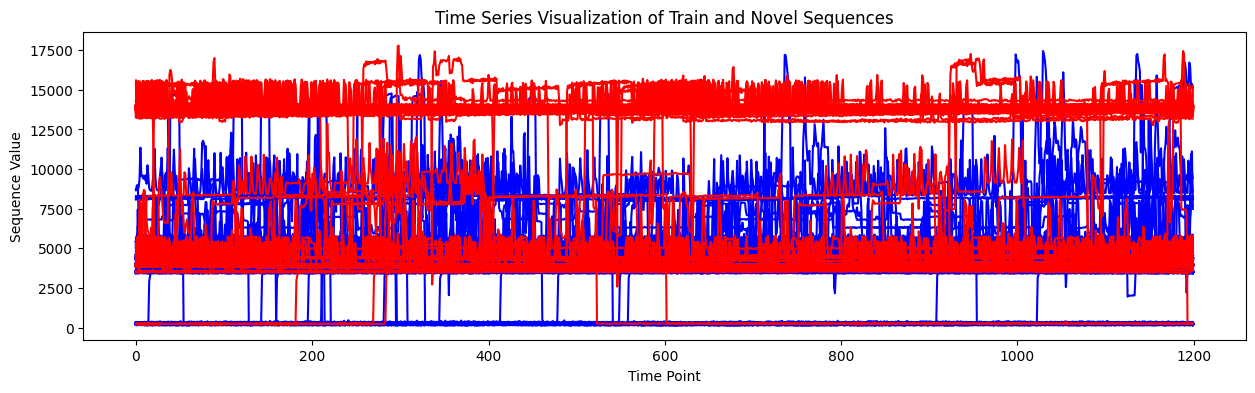

In [182]:
plt.figure(figsize=(15, 4))

# Plot train sequences
for seq in X_nominal:
    plt.plot(range(len(seq)), seq, color='blue', label='Train Sequence')

# Plot novel sequences
for seq in X_novel:
    plt.plot(range(len(seq)), seq, color='red', label='Novel Sequence')

plt.title('Time Series Visualization of Train and Novel Sequences')
plt.xlabel('Time Point')
plt.ylabel('Sequence Value')
# plt.legend(['Train Sequences', 'Novel Sequences'])
# plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(15, 4))

# Plot train sequences without adding a label
for seq in train_sequences_array:
    plt.plot(range(len(seq)), seq, color='blue', alpha=0.7)

# Plot novel sequences without adding a label
for seq in novel_sequences_array:
    plt.plot(range(len(seq)), seq, color='red', alpha=0.7)

# Enhancing the plot
plt.title('Time Series Visualization of Train and Novel Sequences', fontsize=30)
plt.xlabel('Time', fontsize=24)
plt.ylabel('Comsuption', fontsize=24)
plt.grid(True, linestyle='--', alpha=0.5)

# Create custom legend
train_patch = mpatches.Patch(color='blue', label='Train Sequences')
novel_patch = mpatches.Patch(color='red', label='Novel Sequences')
plt.legend(handles=[train_patch, novel_patch])

# Save the plot
file_path_2 = './2.png'
plt.savefig(file_path_2)
plt.show()


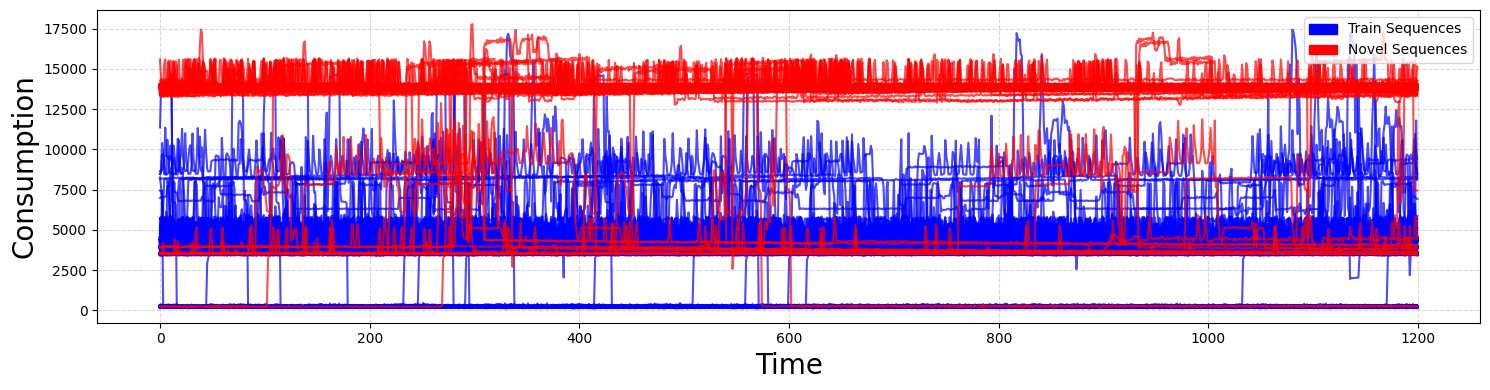

In [54]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(15, 4))

# Plot train sequences without adding a label
for seq in train_sequences_array:
    plt.plot(range(len(seq)), seq, color='blue', alpha=0.7)

# Plot novel sequences without adding a label
for seq in novel_sequences_array:
    plt.plot(range(len(seq)), seq, color='red', alpha=0.7)

# Enhancing the plot
# plt.title('Time Series Visualization of Train and Novel Sequences', fontsize=30)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Consumption', fontsize=20)
plt.grid(True, linestyle='--', alpha=0.5)

# Create custom legend
train_patch = mpatches.Patch(color='blue', label='Train Sequences')
novel_patch = mpatches.Patch(color='red', label='Novel Sequences')
plt.legend(handles=[train_patch, novel_patch])
plt.tight_layout()
# Save the plot
file_path_2 = './2.png'
plt.savefig(file_path_2)
plt.show()


In [32]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
0,221.5,240.5,259.0,228.0,241.5,241.5,234.5,231.0,248.0,242.0,...,233.0,225.0,232.5,238.0,241.0,237.5,241.5,236.5,236.0,224.5
1,238.5,220.0,230.0,235.5,226.0,234.0,242.0,223.5,241.0,248.5,...,240.0,236.0,231.0,228.5,242.0,238.5,229.0,239.5,232.0,241.5
2,3525.0,3503.0,3518.0,3509.0,3530.0,3533.0,3520.0,3536.0,3519.0,3517.5,...,3510.0,3510.5,3514.5,3509.5,3519.0,3533.5,3491.5,3498.0,3495.0,3501.0
3,238.0,236.0,238.0,256.0,228.0,255.0,235.0,240.0,243.0,241.5,...,256.5,249.0,224.5,260.5,232.0,252.0,243.0,239.5,256.0,238.0
4,13980.0,14002.0,14004.0,14007.0,13966.5,13992.5,14019.0,13988.0,13996.5,13992.0,...,3603.0,3611.5,3609.0,3617.0,3626.5,3630.0,3623.0,3612.5,3612.0,3644.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,3512.0,3518.0,3492.5,3505.5,3513.0,3497.5,3528.0,3536.5,3523.0,3541.0,...,3531.0,3533.0,3530.0,3535.5,3496.5,3549.0,3515.5,3532.0,3544.0,3519.0
1376,165.0,152.0,165.0,369.0,299.0,239.5,212.0,175.5,163.0,347.0,...,256.0,271.0,235.0,227.0,291.5,255.5,237.0,237.5,254.0,282.0
1377,233.5,249.0,231.0,249.0,232.5,238.0,230.0,244.0,245.0,248.0,...,244.5,243.5,246.0,242.0,228.5,257.0,239.5,239.0,249.5,244.0
1378,231.0,242.0,234.0,225.5,256.0,257.5,249.5,238.0,232.0,234.0,...,242.0,236.0,274.0,233.0,241.0,223.0,239.0,246.0,238.0,235.5


In [63]:
# novel_sequences_array.reshape((98, 1200,1)).shape

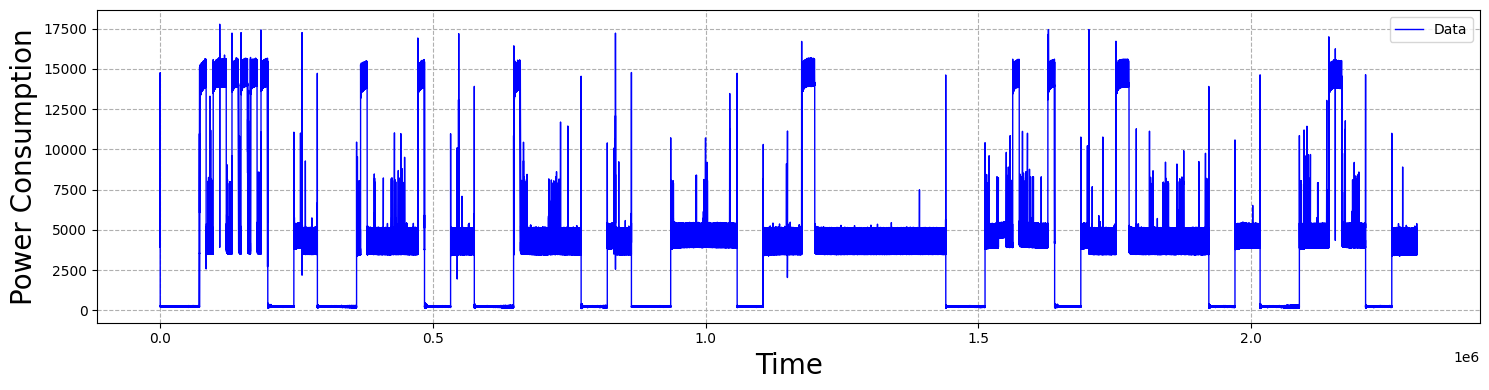

In [51]:
trace_array = np.array(trace)
gt_array = np.array(gt)

# Create a figure
plt.figure(figsize=(15, 4))

# Plot the original data
plt.plot(trace_array, label='Data', color='blue', linewidth=1)

# Find indices where gt is 2
indices_gt_2 = np.where(gt_array == 2)[0]

# Overlay these points in red
# plt.scatter(indices_gt_2, trace_array[indices_gt_2], color='red', s=100, label='Novelties', edgecolor='black', alpha=0.5)

# Enhance the plot with grid, title, and axis labels
# plt.title('Data Plot with Highlighted Points (gt=2)', fontsize=14)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Power Consumption', fontsize=20)
plt.grid(True, linestyle='--', alpha=1)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()

# Save the plot to a file
file_path = './1.png'
plt.savefig(file_path)


In [341]:
X_train_reshaped = train_sequences_array.reshape(train_sequences_array.shape[0], -1)

X_train, X_val = train_test_split(X_train_reshaped, test_size=0.2, random_state=0)

novel_sequences_reshaped = novel_sequences_array.reshape(novel_sequences_array.shape[0], -1)

# Concatenating with the validation set
X_test = np.concatenate((X_val, novel_sequences_reshaped), axis=0)

# XGBOOST


In [507]:
model = XGBRegressor(objective='reg:squarederror', n_estimators=10, verbosity=1,n_jobs = -1)
model.fit(X_train, X_train,verbose=True)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [185]:
model.save_model('xgb_model.bin')

In [509]:
batch_size = 10000 
error = np.empty_like(X_test)

# Process in batches to avoid memory issues
for i in range(0, len(X_test), batch_size):
    end = min(i + batch_size, len(X_test))
    batch_pred = model.predict(X_test[i:end])
    
    # Ensure that batch_pred is reshaped to match the dimensions of X_test
    # If X_test is 2D (n_samples, n_features), batch_pred should also be reshaped to this format
    batch_pred_reshaped = batch_pred.reshape(-1, X_test.shape[1])
    
    # Calculate the error for this batch
    error[i:end] = X_test[i:end] - batch_pred_reshaped


In [510]:
anomalies_binary

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [522]:
from sklearn.metrics import classification_report

# Assuming error is already computed
threshold = np.percentile(np.abs(error), 30)
anomalies = np.abs(error) > threshold

# Assuming X_test_train and novel_sequences_array are already defined and correctly shaped
gt_test = np.concatenate((np.zeros(len(X_val)), np.ones(len(novel_sequences_array))))

# Reshape anomalies to match the shape of X_test and then convert to binary format
anomalies_reshaped = anomalies.reshape(X_test.shape[0], -1)
anomalies_binary = anomalies_reshaped.any(axis=1).astype(int)

# Classification report to evaluate model performance
print(classification_report(gt_test, anomalies_binary))

overall_f1 = f1_score(gt_test, anomalies_binary, average='micro')

print("Overall F1 Score:", overall_f1)


              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       159
         1.0       1.00      1.00      1.00      1126

    accuracy                           0.99      1285
   macro avg       0.99      0.99      0.99      1285
weighted avg       0.99      0.99      0.99      1285

Overall F1 Score: 0.9937743190661479


In [512]:
overall_f1 = f1_score(ground_truth, anomalies_binary, average='micro')

ValueError: Found input variables with inconsistent numbers of samples: [82, 1285]

## XGBoost Cross Fold Test

In [193]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, f1_score
from xgboost import XGBRegressor

# Assuming X_train_reshaped and novel_sequences_reshaped are already defined

n_splits = 5
kf = KFold(n_splits=n_splits)

overall_f1_scores = []

for train_index, val_index in kf.split(X_train_reshaped):
    # Splitting data into training and validation sets for the current fold
    
    X_train, X_val = X_train_reshaped[train_index], X_train_reshaped[val_index]

    # Concatenating the validation set with the novel sequences for testing
    X_test = np.concatenate((X_val, novel_sequences_reshaped), axis=0)

    # Training the model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=10, verbosity=1, n_jobs=-1)
    model.fit(X_train, X_train)

    # Process in batches to avoid memory issues
    batch_size = 10000 
    error = np.empty_like(X_test)

    for i in range(0, len(X_test), batch_size):
        end = min(i + batch_size, len(X_test))
        batch_pred = model.predict(X_test[i:end])
        
        # Reshaping batch_pred to match the dimensions of X_test
        batch_pred_reshaped = batch_pred.reshape(-1, X_test.shape[1])
        
        # Calculating the error for this batch
        error[i:end] = X_test[i:end] - batch_pred_reshaped

    # Threshold calculation and anomaly detection
    threshold = np.percentile(np.abs(error), 95)
    anomalies = np.abs(error) > threshold

    gt_test = np.concatenate((np.zeros(len(X_val)), np.ones(len(novel_sequences_reshaped))))

    # Reshaping and converting anomalies to binary format
    anomalies_reshaped = anomalies.reshape(X_test.shape[0], -1)
    anomalies_binary = anomalies_reshaped.any(axis=1).astype(int)

    # Classification report and F1 score calculation
    f1 = f1_score(gt_test, anomalies_binary, average='micro')
    overall_f1_scores.append(f1)

# Averaging the F1 scores across all folds
average_f1_score = np.mean(overall_f1_scores)
print("Average F1 Score across all folds:", average_f1_score)


Average F1 Score across all folds: 0.9881302824159967


In [196]:
overall_f1_scores

[0.9888888888888889,
 0.9833024118738405,
 0.9925788497217068,
 0.9888682745825603,
 0.987012987012987]

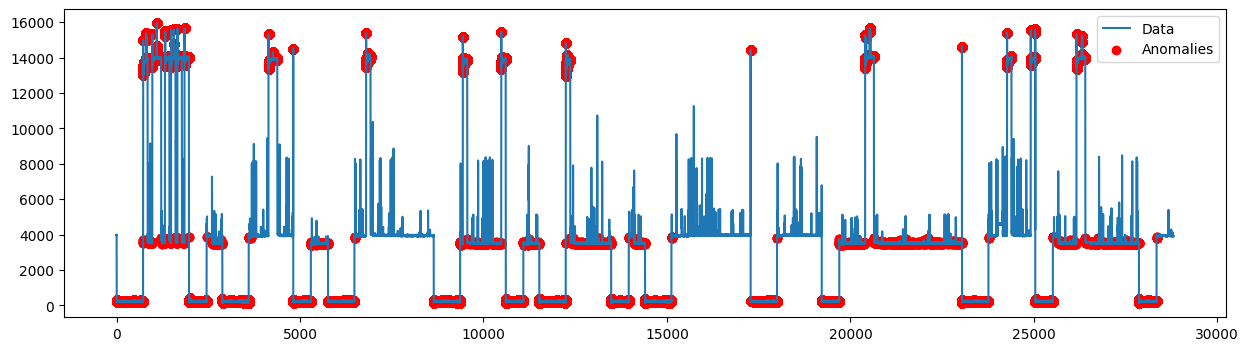

In [40]:
plt.figure(figsize=(15, 4))

# Flatten X_full for consistent dimensions
X_full_flat = X_full.flatten()

# Plot the original data
plt.plot(X_full_flat, label='Data')

# Ensure the lengths of anomalies and X_full_flat are the same
if len(anomalies) != len(X_full_flat):
    # Adjust the length of anomalies to match X_full_flat
    anomalies = anomalies[:len(X_full_flat)]

# Get the indices of anomalies
anomaly_indices = np.where(anomalies)[0]

# Check if anomaly_indices are within the bounds of X_full_flat
anomaly_indices = anomaly_indices[anomaly_indices < len(X_full_flat)]

# Overlay the anomalies
plt.scatter(anomaly_indices, X_full_flat[anomaly_indices], color='red', label='Anomalies')

plt.legend()
plt.show()


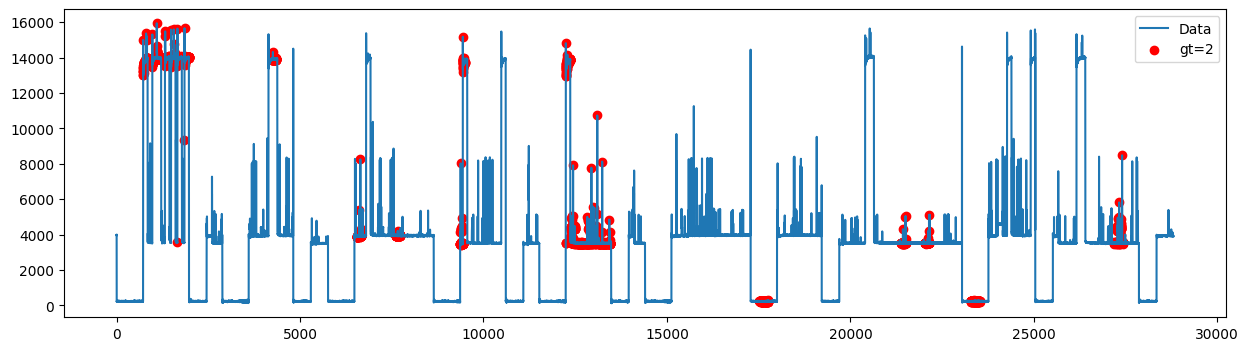

In [73]:
trace_array = np.array(trace_df_without_label)
gt_array = np.array(gt)

# Create a figure
plt.figure(figsize=(15, 4))

# Plot the original data
plt.plot(trace_array, label='Data')

# Find indices where gt is 3
indices_gt_3 = np.where(gt_array == 2)[0]

# Overlay these points in red
plt.scatter(indices_gt_3, trace_array[indices_gt_3], color='red', label='gt=2')

# Add legend and show the plot
plt.legend()
plt.show()


# KMEANS

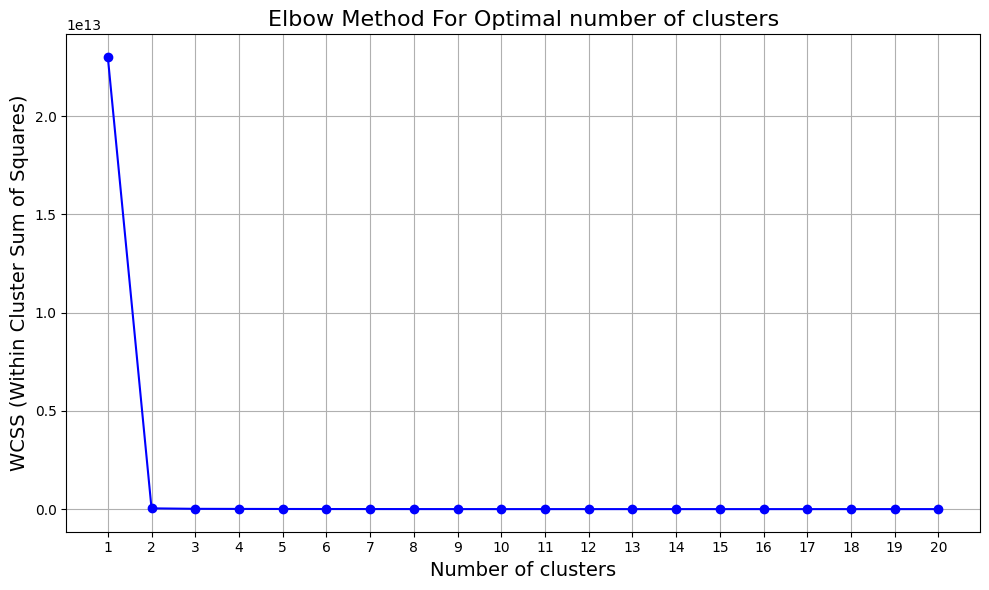

In [6]:
wcss = []
for i in range(1, 21):  # Testing 1 to 20 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)

# Plotting the results onto a line graph to observe 'The Elbow'
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), wcss, marker='o', linestyle='-', color='blue')
plt.title('Elbow Method For Optimal number of clusters', fontsize=16)
plt.xlabel('Number of clusters', fontsize=14)
plt.xticks(range(1, 21))  # Ensure x-axis labels are integer values
plt.ylabel('WCSS (Within Cluster Sum of Squares)', fontsize=14)
plt.grid(True)
plt.tight_layout()

In [595]:
threshold_constant = len(X_val) /( len(X_val ) + len(novel_sequences_array))
threshold_constant

0.6407407407407407

In [33]:
n_clusters = 3

threshold_constant = len(X_val) /( len(X_val ) + len(novel_sequences_array))
threshold_constant
# Train K-Means on the training data
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X_train)

joblib.dump(kmeans, 'kmeans.pkl')

# Find the distance of each point in the test set to the nearest cluster center
distances = kmeans.transform(X_test)
min_distances = np.min(distances, axis=1)

threshold = np.percentile(min_distances, threshold_constant*100)  

# Identify novelties
# A novelty in this case is a data point whose distance to the nearest cluster center is greater than the threshold
novelties = min_distances > threshold

# Ground truth - assuming the first part of X_test is normal (0) and the latter part is novel/anomalous (1)
ground_truth = np.concatenate((np.zeros(len(X_val)), np.ones(len(novel_sequences_array))))

# Classification report
print(classification_report(ground_truth, novelties))


overall_f1 = f1_score(ground_truth, novelties, average='micro')

print("Overall F1 Score:", overall_f1)

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       346
         1.0       0.99      0.99      0.99       194

    accuracy                           0.99       540
   macro avg       0.99      0.99      0.99       540
weighted avg       0.99      0.99      0.99       540

Overall F1 Score: 0.9925925925925926


In [198]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, f1_score
from sklearn.cluster import KMeans
import joblib

# Assuming X_train_reshaped and novel_sequences_reshaped are already defined

n_splits = 5
kf = KFold(n_splits=n_splits)

overall_f1_scores = []

for train_index, val_index in kf.split(X_train_reshaped):
    # Splitting data into training and validation sets for the current fold
    X_train, X_val = X_train_reshaped[train_index], X_train_reshaped[val_index]

    # Concatenating the validation set with the novel sequences for testing
    X_test = np.concatenate((X_val, novel_sequences_reshaped), axis=0)

    # Training the K-Means model
    n_clusters = 5
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X_train)
    
    # Finding the distance of each point in the test set to the nearest cluster center
    distances = kmeans.transform(X_test)
    min_distances = np.min(distances, axis=1)

    # Setting the threshold for novelty detection
    threshold = np.percentile(min_distances, 65)

    # Identifying novelties
    novelties = min_distances > threshold

    # Ground truth
    ground_truth = np.concatenate((np.zeros(len(X_val)), np.ones(len(novel_sequences_reshaped))))

    # Classification report and F1 score
    f1 = f1_score(ground_truth, novelties, average='micro')
    overall_f1_scores.append(f1)

# Averaging the F1 scores across all folds
average_f1_score = np.mean(overall_f1_scores)
print("Average F1 Score across all folds:", average_f1_score)


Average F1 Score across all folds: 0.9907269978698551


In [199]:
overall_f1_scores

[0.9907407407407407,
 0.9907235621521335,
 0.9907235621521335,
 0.9907235621521335,
 0.9907235621521335]

# DBSCAN

In [597]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import classification_report, f1_score

# Standardize each time series independently
X_train_scaled = np.array([StandardScaler().fit_transform(x.reshape(-1, 1)).flatten() for x in X_train])
X_test_scaled = np.array([StandardScaler().fit_transform(x.reshape(-1, 1)).flatten() for x in X_test])

# Initialize and apply DBSCAN
dbscan = DBSCAN(eps=0.1, min_samples=10)
dbscan.fit(X_train_scaled)

test_labels = dbscan.fit_predict(X_test_scaled)

# Identify novelties
novel_predictions = (test_labels == -1)

# Prepare ground truth labels
ground_truth = np.concatenate((np.zeros(len(X_val)), np.ones(len(novel_sequences_array))))

# Evaluate the model
print("Classification Report:")
print(classification_report(ground_truth, novel_predictions))
print("F1 Score:", f1_score(ground_truth, novel_predictions, average='micro'))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       346
         1.0       0.36      1.00      0.53       194

    accuracy                           0.36       540
   macro avg       0.18      0.50      0.26       540
weighted avg       0.13      0.36      0.19       540

F1 Score: 0.3592592592592593


In [201]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, f1_score
from sklearn.cluster import DBSCAN

# Assuming X_train_reshaped and novel_sequences_reshaped are already defined

n_splits = 5
kf = KFold(n_splits=n_splits)

overall_f1_scores = []

for train_index, val_index in kf.split(X_train_reshaped):
    # Splitting data into training and validation sets for the current fold
    X_train, X_val = X_train_reshaped[train_index], X_train_reshaped[val_index]

    # Concatenating the validation set with the novel sequences for testing
    X_test = np.concatenate((X_val, novel_sequences_reshaped), axis=0)

    # Adjust eps and min_samples as needed
    dbscan = DBSCAN(eps=0.1, min_samples=10) 
    dbscan.fit(X_train)  # Optional, can be used to inform the choice of parameters

    # Predicting on the test set
    test_labels = dbscan.fit_predict(X_test)
    novel_predictions = (test_labels == -1)

    # Ground truth
    ground_truth = np.concatenate((np.zeros(len(X_val)), np.ones(len(novel_sequences_reshaped))))

    # Classification report and F1 score
    f1 = f1_score(ground_truth, novel_predictions, average='micro')
    overall_f1_scores.append(f1)

# Averaging the F1 scores across all folds
average_f1_score = np.mean(overall_f1_scores)
print("Average F1 Score across all folds:", average_f1_score)


Average F1 Score across all folds: 0.35979248264962554


In [202]:
overall_f1_scores

[0.3592592592592593,
 0.35992578849721707,
 0.35992578849721707,
 0.35992578849721707,
 0.35992578849721707]

In [31]:
eps_values = [0.1, 0.2, 0.3, 0.4, 0.5]  
min_samples_values = [3, 5, 7, 10]  # Adjust these values as needed

# Ground truth
ground_truth = np.concatenate((np.zeros(len(X_val)), np.ones(len(novel_sequences_array))))

# Iterate over the ranges
for eps in np.arange(0.5,10,.5):
    for min_samples in range(1,30,2):
        # Initialize and fit DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(X_train)

        # Predict on the test set
        test_labels = dbscan.fit_predict(X_test)
        novel_predictions = (test_labels == -1)

        # Calculate accuracy
        accuracy = accuracy_score(ground_truth, novel_predictions)

        # Print the results
        print(f"eps: {eps}, min_samples: {min_samples}, Accuracy: {accuracy}")


eps: 0.5, min_samples: 1, Accuracy: 0.6407407407407407
eps: 0.5, min_samples: 3, Accuracy: 0.3592592592592593
eps: 0.5, min_samples: 5, Accuracy: 0.3592592592592593
eps: 0.5, min_samples: 7, Accuracy: 0.3592592592592593
eps: 0.5, min_samples: 9, Accuracy: 0.3592592592592593
eps: 0.5, min_samples: 11, Accuracy: 0.3592592592592593
eps: 0.5, min_samples: 13, Accuracy: 0.3592592592592593
eps: 0.5, min_samples: 15, Accuracy: 0.3592592592592593
eps: 0.5, min_samples: 17, Accuracy: 0.3592592592592593
eps: 0.5, min_samples: 19, Accuracy: 0.3592592592592593
eps: 0.5, min_samples: 21, Accuracy: 0.3592592592592593
eps: 0.5, min_samples: 23, Accuracy: 0.3592592592592593
eps: 0.5, min_samples: 25, Accuracy: 0.3592592592592593
eps: 0.5, min_samples: 27, Accuracy: 0.3592592592592593
eps: 0.5, min_samples: 29, Accuracy: 0.3592592592592593
eps: 1.0, min_samples: 1, Accuracy: 0.6407407407407407
eps: 1.0, min_samples: 3, Accuracy: 0.3592592592592593
eps: 1.0, min_samples: 5, Accuracy: 0.3592592592592593


In [51]:

# Fit DBSCAN on the training data
dbscan = DBSCAN(eps=1, min_samples=1)  # Adjust these parameters as needed
dbscan.fit(X_train_flat)


test_labels = dbscan.fit_predict(X_test_flat)

# Novelty detection
# Novel points are those not belonging to any cluster (-1 label)
novel_predictions = (test_labels == -1)

# Prepare ground truth labels for test data (1 for novel, 0 for normal)
ground_truth = np.concatenate((np.zeros(len(X_test_normal)), np.ones(len(novel_sequences_array))))

# Evaluate the model
print(classification_report(ground_truth, novel_predictions))

NameError: name 'X_train_flat' is not defined

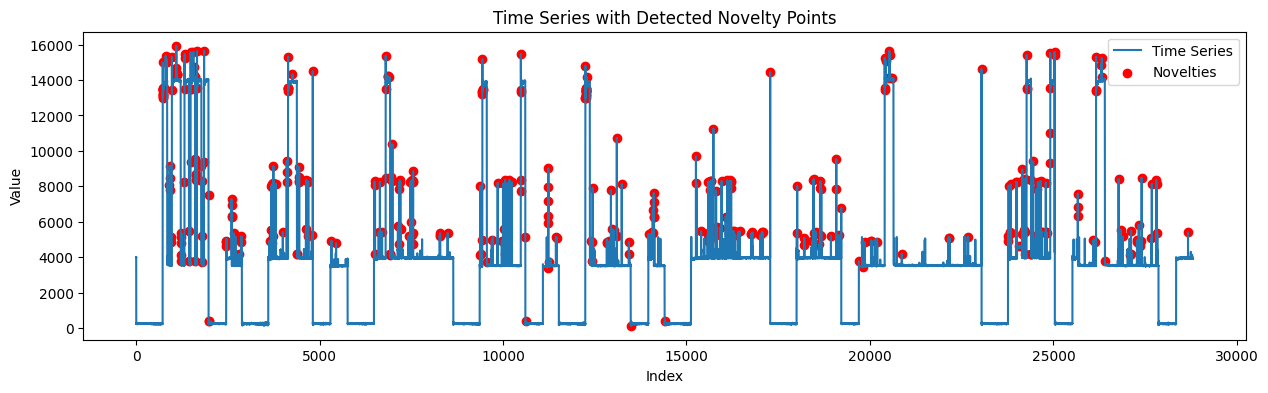

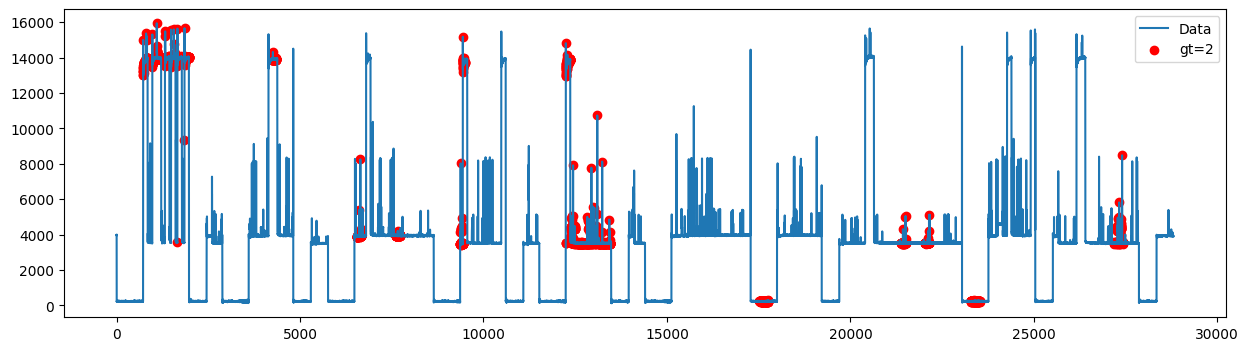

In [12]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=10, min_samples=10)  
dbscan.fit(X_train.reshape(-1, 1))
# Predict on X_test
test_labels = dbscan.fit_predict(X_full.reshape(-1, 1))

# Novelty detection
novel_points = X_full[test_labels == -1]  # Points labeled as -1 are considered novel
# Correcting the plot: now using the index as the x-axis and the values of X_full as the y-axis.

plt.figure(figsize=(15, 4))

# Plotting the full series
plt.plot(range(len(X_full)), X_full, label='Time Series')

# Highlighting novel points
novel_indices = np.where(test_labels == -1)[0]  # Get indices of novel points
plt.scatter(novel_indices, X_full[novel_indices], color='red', label='Novelties')

plt.title('Time Series with Detected Novelty Points')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()


trace_array = np.array(trace_df_without_label)
gt_array = np.array(gt)

# Create a figure
plt.figure(figsize=(15, 4))

# Plot the original data
plt.plot(trace_array, label='Data')

# Find indices where gt is 3
indices_gt_3 = np.where(gt_array == 2)[0]

# Overlay these points in red
plt.scatter(indices_gt_3, trace_array[indices_gt_3], color='red', label='gt=2')

# Add legend and show the plot
plt.legend()
plt.show()



In [13]:
from sklearn.metrics import classification_report

# Assuming gt_array contains the true labels (0 for normal, 1 for novel)
true_labels = (gt_array == 2).astype(int)  # Convert to binary format

# DBSCAN Predictions
dbscan_predictions = (test_labels == -1).astype(int)

# Calculate metrics for DBSCAN
print("DBSCAN Detector Metrics:")
print(classification_report(true_labels, dbscan_predictions))

DBSCAN Detector Metrics:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     25310
           1       0.25      0.03      0.05      3494

    accuracy                           0.87     28804
   macro avg       0.56      0.51      0.49     28804
weighted avg       0.80      0.87      0.82     28804



array([1., 1., 0., ..., 1., 1., 1.])

In [35]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=10, min_samples=10)  # Adjust eps and min_samples as needed
dbscan.fit(X_train.reshape(-1, 1))


DBSCAN(eps=10, min_samples=10)

In [29]:
# Predict on X_test
test_labels = dbscan.fit_predict(X_full.reshape(-1, 1))

# Novelty detection
novel_points = X_full[test_labels == -1]  # Points labeled as -1 are considered novel

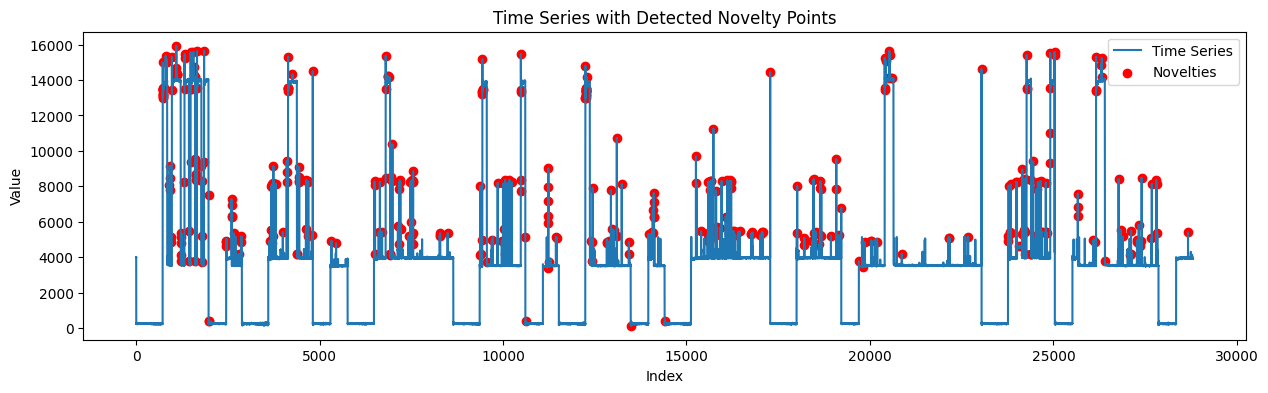

In [30]:
# Correcting the plot: now using the index as the x-axis and the values of X_full as the y-axis.

plt.figure(figsize=(15, 4))

# Plotting the full series
plt.plot(range(len(X_full)), X_full, label='Time Series')

# Highlighting novel points
novel_indices = np.where(test_labels == -1)[0]  # Get indices of novel points
plt.scatter(novel_indices, X_full[novel_indices], color='red', label='Novelties')

plt.title('Time Series with Detected Novelty Points')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()



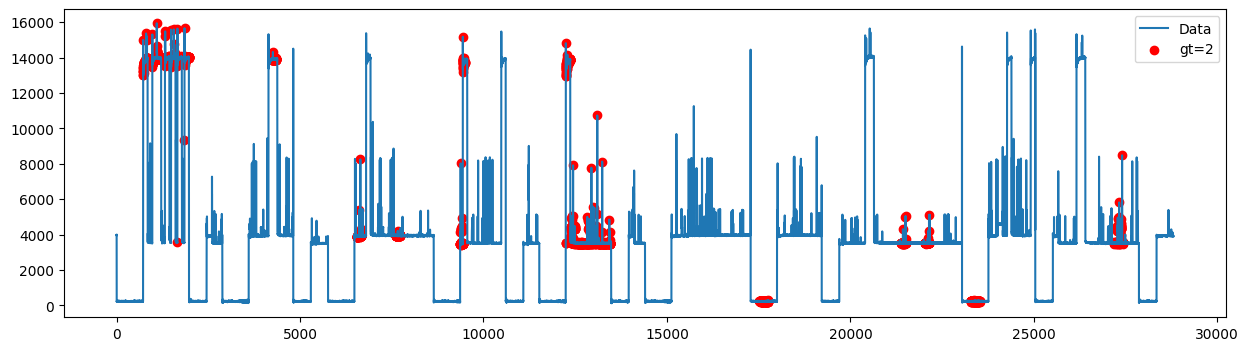

In [31]:
trace_array = np.array(trace_df_without_label)
gt_array = np.array(gt)

# Create a figure
plt.figure(figsize=(15, 4))

# Plot the original data
plt.plot(trace_array, label='Data')

# Find indices where gt is 3
indices_gt_3 = np.where(gt_array == 2)[0]

# Overlay these points in red
plt.scatter(indices_gt_3, trace_array[indices_gt_3], color='red', label='gt=2')

# Add legend and show the plot
plt.legend()
plt.show()


In [32]:
train_labels = dbscan.labels_

# Counting the number of clusters (excluding noise points labeled as -1)
num_clusters = len(set(train_labels)) - (1 if -1 in train_labels else 0)

num_clusters


13

## One Class SVM

In [533]:
X_train.shape

(635, 1200)

In [534]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)

In [535]:
X_test.shape

(1285, 1200)

In [536]:
gt_test.shape

(1285,)

In [537]:
novel_sequences_array.shape


(1126, 1200, 1)

In [598]:
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Standardizing the data
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_test_flat = scaler.transform(X_test_flat)

# Initialize and fit One-Class SVM
model = OneClassSVM(kernel='rbf', gamma='scale', nu=0.01)
model.fit(X_train_flat)

# Predict on the test set
novelties = model.predict(X_test_flat)

# Convert predictions to binary format (0 for normal, 1 for anomaly)
novelties_binary = (novelties == -1).astype(int)

gt_test = np.concatenate( (np.zeros(len(X_val)), np.ones(len(novel_sequences_array))))

# Classification report to evaluate model performance
print("Classification Report:")
print(classification_report(gt_test, novelties_binary))

# F1 Score
print("F1 Score:", f1_score(gt_test, novelties_binary))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       346
         1.0       0.96      0.99      0.98       194

    accuracy                           0.98       540
   macro avg       0.98      0.98      0.98       540
weighted avg       0.98      0.98      0.98       540

F1 Score: 0.9770992366412214


In [204]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, f1_score
from sklearn.svm import OneClassSVM

# Assuming X_train_reshaped and novel_sequences_reshaped are already defined

n_splits = 5
kf = KFold(n_splits=n_splits)

overall_f1_scores = []

for train_index, val_index in kf.split(X_train_reshaped):
    # Splitting data into training and validation sets for the current fold
    X_train, X_val = X_train_reshaped[train_index], X_train_reshaped[val_index]

    # Concatenating the validation set with the novel sequences for testing
    X_test = np.concatenate((X_val, novel_sequences_reshaped), axis=0)

    # Initialize One-Class SVM model
    model = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)  # adjust parameters as needed

    # Train the model on normal data (training set)
    model.fit(X_train)

    # Predict on the test set
    batch_size = 10000
    # Initialize anomalies as a 1D array
    novelties = np.empty(len(X_test), dtype=int)

    # Process in batches to avoid memory issues
    for i in range(0, len(X_test), batch_size):
        end = min(i + batch_size, len(X_test))
        # -1 for anomalies, 1 for normal
        batch_pred = model.predict(X_test[i:end])
        
        # Store the predictions
        novelties[i:end] = batch_pred

    # Convert predictions to binary format (0 for normal, 1 for anomaly)
    novelties_binary = (novelties == -1).astype(int)

    # Ground truth
    ground_truth = np.concatenate((np.zeros(len(X_val)), np.ones(len(novel_sequences_reshaped))))

    # Classification report and F1 score
    f1 = f1_score(ground_truth, novelties_binary, average='micro')
    overall_f1_scores.append(f1)

# Averaging the F1 scores across all folds
average_f1_score = np.mean(overall_f1_scores)
print("Average F1 Score across all folds:", average_f1_score)


Average F1 Score across all folds: 0.35979248264962554


In [205]:
overall_f1_scores

[0.3592592592592593,
 0.35992578849721707,
 0.35992578849721707,
 0.35992578849721707,
 0.35992578849721707]

In [364]:
X_train.shape

(1012, 1200)

In [362]:
X_train_flat = train_sequences_array.reshape(X_train.shape[0], -1)

# Initialize and fit One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', nu=0.01)  # Adjust kernel and nu as needed
oc_svm.fit(X_train_flat)

# Preparing the test data
X_test_normal, _ = train_test_split(train_sequences_array, test_size=0.5, random_state=0)
X_test = np.concatenate((X_test_normal, novel_sequences_array), axis=0)

# Flatten the test data
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Predict on the test data
svm_labels = oc_svm.predict(X_test_flat)

# Novelty detection: Points labeled as -1 are considered novel
novel_predictions = (svm_labels == -1)

# Prepare ground truth labels for test data (1 for novel, 0 for normal)
ground_truth = np.concatenate((np.zeros(len(X_test_normal)), np.ones(len(novel_sequences_array))))

# Evaluate the model
print(classification_report(ground_truth,novel_predictions))
print(f1_score(ground_truth,novel_predictions))


ValueError: cannot reshape array of size 1519200 into shape (1012,newaxis)

In [1]:
from sklearn.svm import OneClassSVM


oc_svm = OneClassSVM(kernel='rbf', nu=0.2)  # Adjust the kernel and nu as needed
oc_svm.fit(X_train.reshape(-1, 1))

# Predict on X_full
svm_labels = oc_svm.predict(X_full.reshape(-1, 1))

# Novelty detection
novel_points_svm = X_full[svm_labels == -1]  # Points labeled as -1 are considered novel


# Plotting
plt.figure(figsize=(15, 4))
plt.plot(range(len(X_full)), X_full, label='Time Series')
plt.scatter(np.where(svm_labels == -1)[0], novel_points_svm, color='red', label='Novelties')
plt.title('Time Series with Detected Novelty Points (One-Class SVM)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()


NameError: name 'X_train' is not defined

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming the following variables are defined as per your example:
# true_anomalies: binary array indicating true anomalies
# anomalies: boolean array indicating detected anomalies based on the threshold

# Convert anomalies to binary format: 1 for anomalies, 0 for normal
anomalies_binary = anomalies.astype(int)

# Ensure the length of anomalies matches the length of true_anomalies
anomalies_binary = anomalies_binary[:len(true_anomalies)]

# Compute and print the classification report
print(classification_report(true_anomalies, anomalies_binary))


## Autoencoder

In [416]:
# X_train_scaled = np.array([MinMaxScaler(feature_range=(-1, 1)).fit_transform(x.reshape(-1, 1)).flatten() for x in X_train])
# X_test_scaled = np.array([MinMaxScaler(feature_range=(-1, 1)).fit_transform(x.reshape(-1, 1)).flatten() for x in X_test])

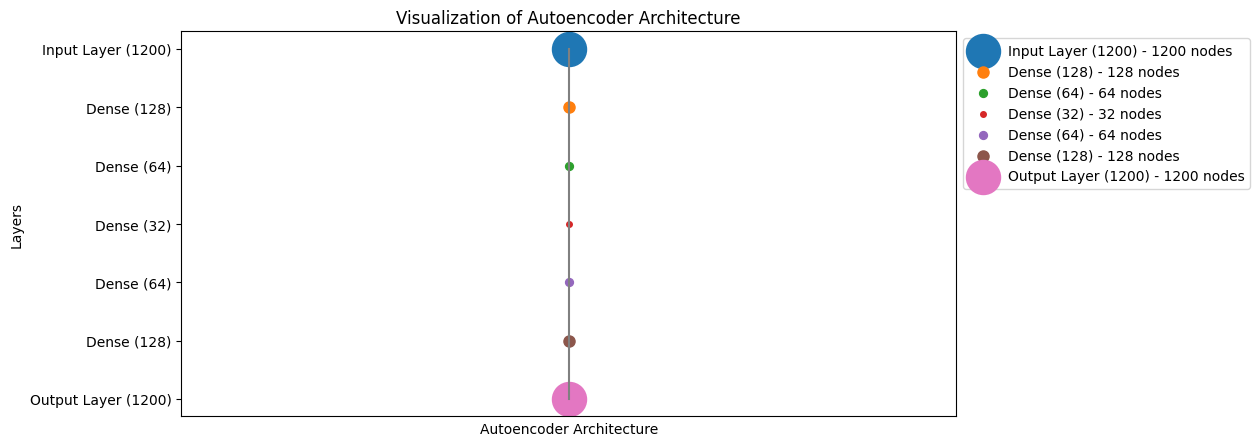

In [34]:
import matplotlib.pyplot as plt

# Define the layers and nodes in each layer
layers = ['Input Layer (1200)', 'Dense (128)', 'Dense (64)', 'Dense (32)',
          'Dense (64)', 'Dense (128)', 'Output Layer (1200)']
nodes = [1200, 128, 64, 32, 64, 128, 1200]

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
y = range(len(layers), 0, -1)  # reverse to match layers from input to output

# Plot the nodes
for i, (layer, node) in enumerate(zip(layers, nodes)):
    ax.scatter([1], [y[i]], s=node/2, label=f'{layer} - {node} nodes')

# Connect nodes with lines
for i in range(len(y) - 1):
    ax.plot([1, 1], [y[i], y[i + 1]], 'gray')

# Set properties
ax.set_xlabel('Autoencoder Architecture')
ax.set_ylabel('Layers')
ax.set_yticks(y)
ax.set_yticklabels(layers)
ax.set_xticks([])
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
ax.grid(False)  # Turn off grid

# Display the plot
plt.title('Visualization of Autoencoder Architecture')
plt.show()


In [5]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

input_layer = Input(shape=(X_train.shape[1],))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(X_train.shape[1], activation='linear')(decoded)

autoencoder = Model(input_layer, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=200, batch_size=32, verbose=1)

autoencoder.save('autoencoder_model.h5')

# Predict on the test set
X_test_scaled = scaler.transform(X_test)
y_test_pred = autoencoder.predict(X_test)

# Calculate the reconstruction error
reconstruction_error = np.mean(np.abs(X_test_scaled - y_test_pred), axis=1)

# Set a threshold for anomaly detection
threshold = np.percentile(reconstruction_error, 90)

# Detect anomalies
anomalies = reconstruction_error > threshold

2024-04-15 22:17:59.547193: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [23]:
from tensorflow.keras.utils import plot_model

# After creating your model, you can plot it:
plot_model(autoencoder, to_file='autoencoder_model.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [600]:
threshold_constant

0.6407407407407407

In [652]:
# Calculate the reconstruction error
reconstruction_error = np.mean(np.abs(X_test_scaled- y_test_pred), axis=1)

# Set a threshold for anomaly detection
# threshold_constant * 100
threshold = np.percentile(reconstruction_error, 70)

# Detect anomalies
anomalies = reconstruction_error > threshold

# Evaluation
ground_truth = np.concatenate((np.zeros(len(X_val)), np.ones(len(novel_sequences_array))))
# print("Shapes - true_anomalies:", true_anomalies.shape, "anomalies:", anomalies.shape)
print(classification_report(ground_truth, anomalies))

overall_f1 = f1_score(ground_truth, anomalies, average='micro')

print("Overall F1 Score:", overall_f1)


              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       346
         1.0       1.00      0.84      0.91       194

    accuracy                           0.94       540
   macro avg       0.96      0.92      0.93       540
weighted avg       0.95      0.94      0.94       540

Overall F1 Score: 0.9407407407407408


# VAE

In [561]:
X_test.shape

(1285, 1200)

In [670]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

# Assuming X_train is your original data
# Normalize your data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
# X_train_scaled = np.array([MinMaxScaler(feature_range=(-1, 1)).fit_transform(x.reshape(-1, 1)).flatten() for x in X_train])
# X_test_scaled = np.array([MinMaxScaler(feature_range=(-1, 1)).fit_transform(x.reshape(-1, 1)).flatten() for x in X_test])

# VAE Model
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = mean_squared_error(data, reconstruction) * X_train.shape[1]
            kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
            total_loss = K.mean(reconstruction_loss + kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": total_loss}

# Encoder
input_layer = Input(shape=(X_train_scaled.shape[1],))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
z_mean = Dense(32)(encoded)
z_log_var = Dense(32)(encoded)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], K.int_shape(z_mean)[1]))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# Decoder
decoded = Dense(64, activation='relu')(z)
decoded = Dense(128, activation='relu')(decoded)
decoded_output = Dense(X_train_scaled.shape[1], activation='linear')(decoded)

# Define the encoder and decoder models
encoder = Model(input_layer, [z_mean, z_log_var, z])
decoder = Model(z, decoded_output)

# Initialize and compile VAE model
vae = VAE(encoder, decoder)
vae.compile(optimizer=Adam())

# Train the model
vae.fit(X_train_scaled, epochs=100, batch_size=16, verbose=1)



Epoch 1/100
40/40 [==============================] - 1s 3ms/step - loss: 89.0114
Epoch 2/100
40/40 [==============================] - 0s 3ms/step - loss: 21.6854
Epoch 3/100
40/40 [==============================] - 0s 3ms/step - loss: 11.9904
Epoch 4/100
40/40 [==============================] - 0s 3ms/step - loss: 12.3747
Epoch 5/100
40/40 [==============================] - 0s 3ms/step - loss: 9.6069
Epoch 6/100
40/40 [==============================] - 0s 3ms/step - loss: 9.2516
Epoch 7/100
40/40 [==============================] - 0s 3ms/step - loss: 13.0545
Epoch 8/100
40/40 [==============================] - 0s 4ms/step - loss: 9.0539
Epoch 9/100
40/40 [==============================] - 0s 3ms/step - loss: 10.7885
Epoch 10/100
40/40 [==============================] - 0s 3ms/step - loss: 8.8417
Epoch 11/100
40/40 [==============================] - 0s 3ms/step - loss: 10.0125
Epoch 12/100
40/40 [==============================] - 0s 3ms/step - loss: 7.6547
Epoch 13/100
40/40 [==========

In [679]:
# Scale X_test in the same way as X_train
X_test_scaled = scaler.transform(X_test)

# Use the VAE model to reconstruct X_tes
reconstructed_X_test = vae.predict(X_test_scaled)

# Now, you can calculate the reconstruction error or perform other analyses
reconstruction_error = np.mean(np.abs(X_test_scaled - reconstructed_X_test), axis=1)
threshold = np.percentile(reconstruction_error, 9) 

ground_truth = np.concatenate((np.zeros(len(X_val)), np.ones(len(novel_sequences_array))))

anomalies = reconstruction_error > threshold
print(classification_report(ground_truth, anomalies))

overall_f1 = f1_score(ground_truth, anomalies, average='micro')

print("Overall F1 Score:", overall_f1)

41/41 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

         0.0       0.98      0.72      0.83       159
         1.0       0.96      1.00      0.98      1126

    accuracy                           0.96      1285
   macro avg       0.97      0.86      0.90      1285
weighted avg       0.96      0.96      0.96      1285

Overall F1 Score: 0.9634241245136187


# CNN


In [641]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Reshape,UpSampling1D
from tensorflow.keras.models import Model

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# X_train_scaled = np.array([MinMaxScaler(feature_range=(-1, 1)).fit_transform(x.reshape(-1, 1)).flatten() for x in X_train])
# X_test_scaled = np.array([MinMaxScaler(feature_range=(-1, 1)).fit_transform(x.reshape(-1, 1)).flatten() for x in X_test])


X_train_reshaped = np.expand_dims(X_train_scaled, axis=2)


input_shape = (X_train_reshaped.shape[1], 1)  # Sequence length, 1

input_layer = Input(shape=input_shape)

# Encoder
x = Conv1D(32, 16, activation="relu", padding="same")(input_layer)
x = MaxPooling1D(2, padding="same")(x)
x = Conv1D(32, 16, activation="relu", padding="same")(x)
x = MaxPooling1D(2, padding="same")(x)
x = Conv1D(10, 8, activation="relu", padding="same")(x)
x = MaxPooling1D(2, padding="same")(x)
x = Conv1D(10, 8, activation="relu", padding="same")(x)
encoded = MaxPooling1D(2, padding="same")(x)

# Decoder
x = Conv1D(10, 8, activation="relu", padding="same")(encoded)
x = UpSampling1D(2)(x)
x = Conv1D(10, 8, activation="relu", padding="same")(x)
x = UpSampling1D(2)(x)
x = Conv1D(32, 16, activation="relu", padding="same")(x)
x = UpSampling1D(2)(x)
x = Conv1D(32, 16, activation="relu", padding="same")(x)
x = UpSampling1D(2)(x)
decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x)

# Autoencoder Model
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
autoencoder.summary()


Model: "model_98"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_100 (InputLayer)      [(None, 1200, 1)]         0         
                                                                 
 conv1d_82 (Conv1D)          (None, 1200, 32)          544       
                                                                 
 max_pooling1d_36 (MaxPooli  (None, 600, 32)           0         
 ng1D)                                                           
                                                                 
 conv1d_83 (Conv1D)          (None, 600, 32)           16416     
                                                                 
 max_pooling1d_37 (MaxPooli  (None, 300, 32)           0         
 ng1D)                                                           
                                                                 
 conv1d_84 (Conv1D)          (None, 300, 10)           257

In [642]:
autoencoder.fit(X_train_reshaped, X_train_reshaped, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
44/44 [==============================] - 8s 49ms/step - loss: 0.0460
Epoch 2/50
44/44 [==============================] - 2s 50ms/step - loss: 0.0035
Epoch 3/50
44/44 [==============================] - 2s 48ms/step - loss: 0.0026
Epoch 4/50
44/44 [==============================] - 2s 49ms/step - loss: 0.0023
Epoch 5/50
44/44 [==============================] - 2s 48ms/step - loss: 0.0018
Epoch 6/50
44/44 [==============================] - 2s 49ms/step - loss: 0.0018
Epoch 7/50
44/44 [==============================] - 2s 50ms/step - loss: 0.0015
Epoch 8/50
44/44 [==============================] - 2s 49ms/step - loss: 0.0014
Epoch 9/50
44/44 [==============================] - 2s 49ms/step - loss: 0.0013
Epoch 10/50
44/44 [==============================] - 2s 49ms/step - loss: 0.0013
Epoch 11/50
44/44 [==============================] - 2s 50ms/step - loss: 0.0011
Epoch 12/50
44/44 [==============================] - 2s 49ms/step - loss: 0.0011
Epoch 13/50
44/44 [==================

In [629]:
autoencoder.save('cnn_autoencoder.h5')

In [643]:
X_test_scaled = scaler.transform(X_test)
X_test_reshaped = np.expand_dims(X_test_scaled, axis=2)
y_test_pred = autoencoder.predict(X_test_reshaped)
reconstruction_error = np.mean(np.abs(X_test_reshaped - y_test_pred), axis=1)
threshold = np.percentile(reconstruction_error, 90)
anomalies = reconstruction_error > threshold

17/17 [==============================] - 0s 13ms/step


In [644]:
ground_truth.shape

(540,)

In [647]:
# X_test_scaled = scaler.transform(X_test)
X_test_reshaped = np.expand_dims(X_test_scaled, axis=2)
y_test_pred = autoencoder.predict(X_test_reshaped)
reconstruction_error = np.mean(np.abs(X_test_reshaped - y_test_pred), axis=1)
threshold = np.percentile(reconstruction_error, threshold_constant * 100)

anomalies = reconstruction_error > threshold
ground_truth = np.concatenate((np.zeros(len(X_val)), np.ones(len(novel_sequences_array))))
print(classification_report(ground_truth, anomalies))

overall_f1 = f1_score(ground_truth, anomalies, average='micro')
print("Overall F1 Score:", overall_f1)


17/17 [==============================] - 0s 13ms/step
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       346
         1.0       0.99      0.99      0.99       194

    accuracy                           0.99       540
   macro avg       0.99      0.99      0.99       540
weighted avg       0.99      0.99      0.99       540

Overall F1 Score: 0.9925925925925926


# GANS

In [661]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = np.array([MinMaxScaler(feature_range=(-1, 1)).fit_transform(x.reshape(-1, 1)).flatten() for x in X_train])
X_test_scaled = np.array([MinMaxScaler(feature_range=(-1, 1)).fit_transform(x.reshape(-1, 1)).flatten() for x in X_test])

In [662]:
from keras.layers import Input, Dense, LeakyReLU
from keras.models import Model
from keras.optimizers import Adam
import numpy as np

def build_generator(input_dim, output_dim):
    input_layer = Input(shape=(input_dim,))
    x = Dense(128)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(output_dim, activation='tanh')(x)
    return Model(input_layer, x)

def build_discriminator(input_dim):
    input_layer = Input(shape=(input_dim,))
    x = Dense(128)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1, activation='sigmoid')(x)
    return Model(input_layer, x)

# Hyperparameters
input_dim = 1200  # Feature size of your data
latent_dim = 100  # Latent dimension for the generator

# Build and compile the discriminator
discriminator = build_discriminator(input_dim)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Build the generator
generator = build_generator(latent_dim, input_dim)

# The generator takes noise as input and generates data
z = Input(shape=(latent_dim,))
generated_data = generator(z)

# Only the generator is trained in the combined model
discriminator.trainable = False
validity = discriminator(generated_data)

# The combined model (generator and discriminator)
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam())

# Train the GAN
batch_size = 16
epochs = 1000
for epoch in range(epochs):
    # Select a random batch of data
    idx = np.random.randint(0, X_train_scaled.shape[0], batch_size)
    real_data = X_train_scaled[idx]

    # Generate a batch of new data
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_data = generator.predict(noise)

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_data, np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator
    g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))
        # Logging the progress
    if epoch % 10 == 0:  # Log at every 10th epoch, can be adjusted
        print(f"Epoch: {epoch}, D Loss: {d_loss[0]:.4f}, G Loss: {g_loss:.4f}")


predictions = discriminator.predict(X_test_scaled)
novelty_scores = 1 - predictions  # Higher score indicates higher chance of being novel


1/1 [==============================] - 0s 33ms/step
Epoch: 0, D Loss: 0.6658, G Loss: 0.7304
1/1 [==============================] - 0s 14ms/step
Epoch: 10, D Loss: 0.4674, G Loss: 1.5342
1/1 [==============================] - 0s 16ms/step
Epoch: 20, D Loss: 0.9551, G Loss: 0.9773
1/1 [==============================] - 0s 15ms/step
Epoch: 30, D Loss: 0.2970, G Loss: 2.6952
1/1 [==============================] - 0s 17ms/step
Epoch: 40, D Loss: 0.3402, G Loss: 4.1451
1/1 [==============================] - 0s 16ms/step
Epoch: 50, D Loss: 0.1647, G Loss: 4.1205
1/1 [==============================] - 0s 16ms/step
Epoch: 60, D Loss: 0.1406, G Loss: 4.9554
1/1 [==============================] - 0s 15ms/step
Epoch: 70, D Loss: 0.2755, G Loss: 4.8141
1/1 [==============================] - 0s 15ms/step
Epoch: 80, D Loss: 0.0817, G Loss: 5.6621
1/1 [==============================] - 0s 15ms/step
Epoch: 90, D Loss: 0.0656, G Loss: 5.3385
1/1 [==============================] - 0s 16ms/step
Epoch: 10

In [663]:
threshold_constant = len(X_val) / (len(X_val) + len(novel_sequences_array) )
threshold_constant

0.6407407407407407

In [666]:
threshold = np.percentile(novelty_scores, 95)

anomalies = novelty_scores > threshold
ground_truth = np.concatenate((np.zeros(len(X_val)), np.ones(len(novel_sequences_array))))
print(classification_report(ground_truth, anomalies))

# print(sns.heatmap(confusion_matrix(ground_truth,anomalies)))
overall_f1 = f1_score(ground_truth, anomalies, average='micro')
print("Overall F1 Score:", overall_f1)



              precision    recall  f1-score   support

         0.0       0.65      0.97      0.78       346
         1.0       0.56      0.08      0.14       194

    accuracy                           0.65       540
   macro avg       0.60      0.52      0.46       540
weighted avg       0.62      0.65      0.55       540

Overall F1 Score: 0.6462962962962963


In [254]:
from keras.layers import Input, Dense, LeakyReLU
from keras.models import Model
from keras.optimizers import Adam
import numpy as np

def build_generator(input_dim, output_dim):
    input_layer = Input(shape=(input_dim,))
    x = Dense(128)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(output_dim, activation='tanh')(x)
    return Model(input_layer, x)

def build_discriminator(input_dim):
    input_layer = Input(shape=(input_dim,))
    x = Dense(128)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1, activation='sigmoid')(x)
    return Model(input_layer, x)

# Hyperparameters
input_dim = 1200  # Feature size of your data
latent_dim = 100  # Latent dimension for the generator

# Build and compile the discriminator
discriminator = build_discriminator(input_dim)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Build the generator
generator = build_generator(latent_dim, input_dim)

# The generator takes noise as input and generates data
z = Input(shape=(latent_dim,))
generated_data = generator(z)

# Only the generator is trained in the combined model
discriminator.trainable = False
validity = discriminator(generated_data)

# The combined model (generator and discriminator)
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam())

# Training the GAN
batch_size = 16
epochs = 50
for epoch in range(epochs):
    # Select a random batch of data
    idx = np.random.randint(0, X_train_scaled.shape[0], batch_size)
    real_data = X_train_scaled[idx]

    # Generate a batch of new data
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_data = generator.predict(noise)

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_data, np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator
    g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

    # Logging the progress
    if epoch % 10 == 0:  # Log at every 10th epoch, can be adjusted
        print(f"Epoch: {epoch}, D Loss: {d_loss[0]:.4f}, G Loss: {g_loss:.4f}")


predictions = discriminator.predict(X_test_scaled)
novelty_scores = 1 - predictions  # Higher score indicates higher chance of being novel


1/1 [==============================] - 0s 36ms/step
Epoch: 0, D Loss: 0.7618, G Loss: 0.9257
1/1 [==============================] - 0s 15ms/step
Epoch: 10, D Loss: 0.3662, G Loss: 1.9510
1/1 [==============================] - 0s 15ms/step
Epoch: 20, D Loss: 0.8318, G Loss: 1.5352
1/1 [==============================] - 0s 15ms/step
Epoch: 30, D Loss: 0.3076, G Loss: 3.3281
1/1 [==============================] - 0s 16ms/step
Epoch: 40, D Loss: 0.1542, G Loss: 4.6535
17/17 [==============================] - 0s 981us/step


In [255]:
print(novelty_scores)

[[7.46607780e-03]
 [4.86496627e-01]
 [4.86806273e-01]
 [7.45481253e-03]
 [3.85475159e-03]
 [4.85924363e-01]
 [4.85810101e-01]
 [3.07494402e-03]
 [4.82532501e-01]
 [6.68489933e-03]
 [4.82317388e-01]
 [4.83950555e-01]
 [3.30317020e-03]
 [3.98492813e-03]
 [4.85118151e-01]
 [7.07858801e-03]
 [4.85962927e-01]
 [7.34680891e-03]
 [7.40265846e-03]
 [7.32547045e-03]
 [3.64321470e-03]
 [7.67844915e-03]
 [3.72618437e-03]
 [7.33494759e-03]
 [4.87062514e-01]
 [7.03918934e-03]
 [1.72209740e-03]
 [6.62285089e-03]
 [7.87615776e-03]
 [7.39264488e-03]
 [3.78388166e-03]
 [4.23192978e-03]
 [1.61302090e-03]
 [3.88407707e-03]
 [6.92784786e-03]
 [4.86992240e-01]
 [4.82128441e-01]
 [4.84642684e-01]
 [4.85856652e-01]
 [1.71285868e-03]
 [4.83938992e-01]
 [4.82437134e-01]
 [4.83937442e-01]
 [6.82407618e-03]
 [5.45793772e-03]
 [7.59643316e-03]
 [7.79032707e-03]
 [7.38191605e-03]
 [7.24560022e-03]
 [7.24828243e-03]
 [1.52748823e-03]
 [6.94119930e-03]
 [4.81035531e-01]
 [4.87543285e-01]
 [7.28905201e-03]
 [4.886607

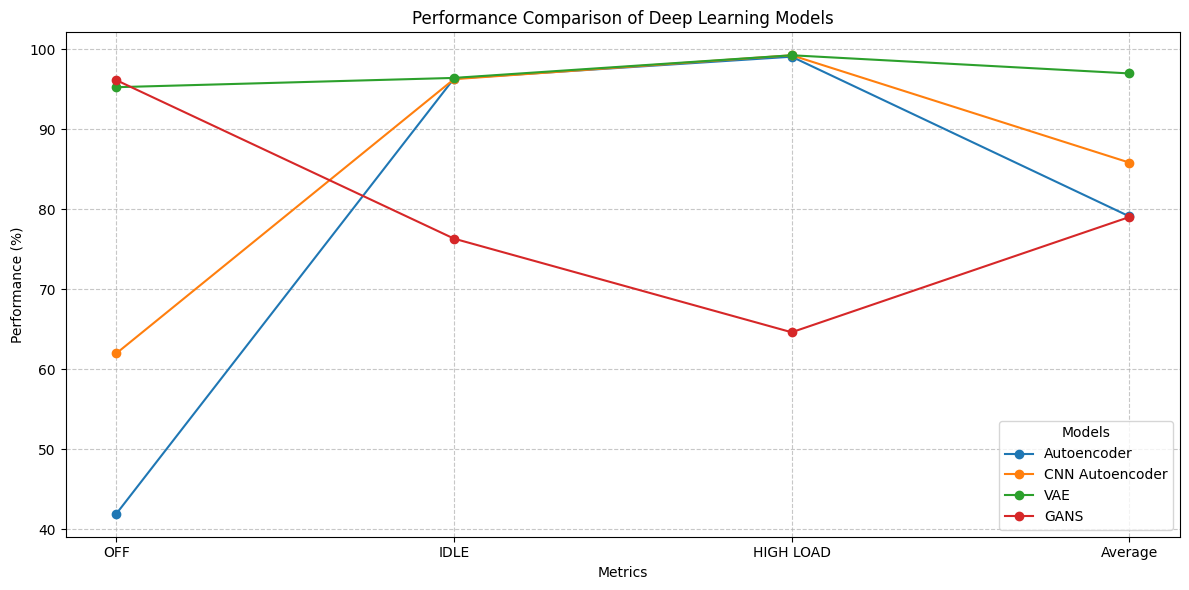

In [689]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for the deep learning models
metrics = ["OFF", "IDLE", "HIGH LOAD", "Average"]
models_data = {
    "Autoencoder": [41.96, 96.34, 99.07, 79.12],
    "CNN Autoencoder": [62, 96.26, 99.25, 85.84],
    "VAE": [95.26, 96.42, 99.25, 96.98],
    "GANS": [96.14, 76.34, 64.64, 79.04]
}

# Creating DataFrame
df = pd.DataFrame(models_data, index=metrics)

# Plotting
plt.figure(figsize=(12, 6))
for model in df.columns:
    plt.plot(df.index, df[model], marker='o', label=model)

plt.title('Performance Comparison of Deep Learning Models')
plt.xlabel('Metrics')
plt.ylabel('Performance (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title="Models")
plt.tight_layout()
plt.savefig("./3.png")
plt.show()


In [50]:
import sklearn
print("Scikit-learn version:", sklearn.__version__)


Scikit-learn version: 1.3.2


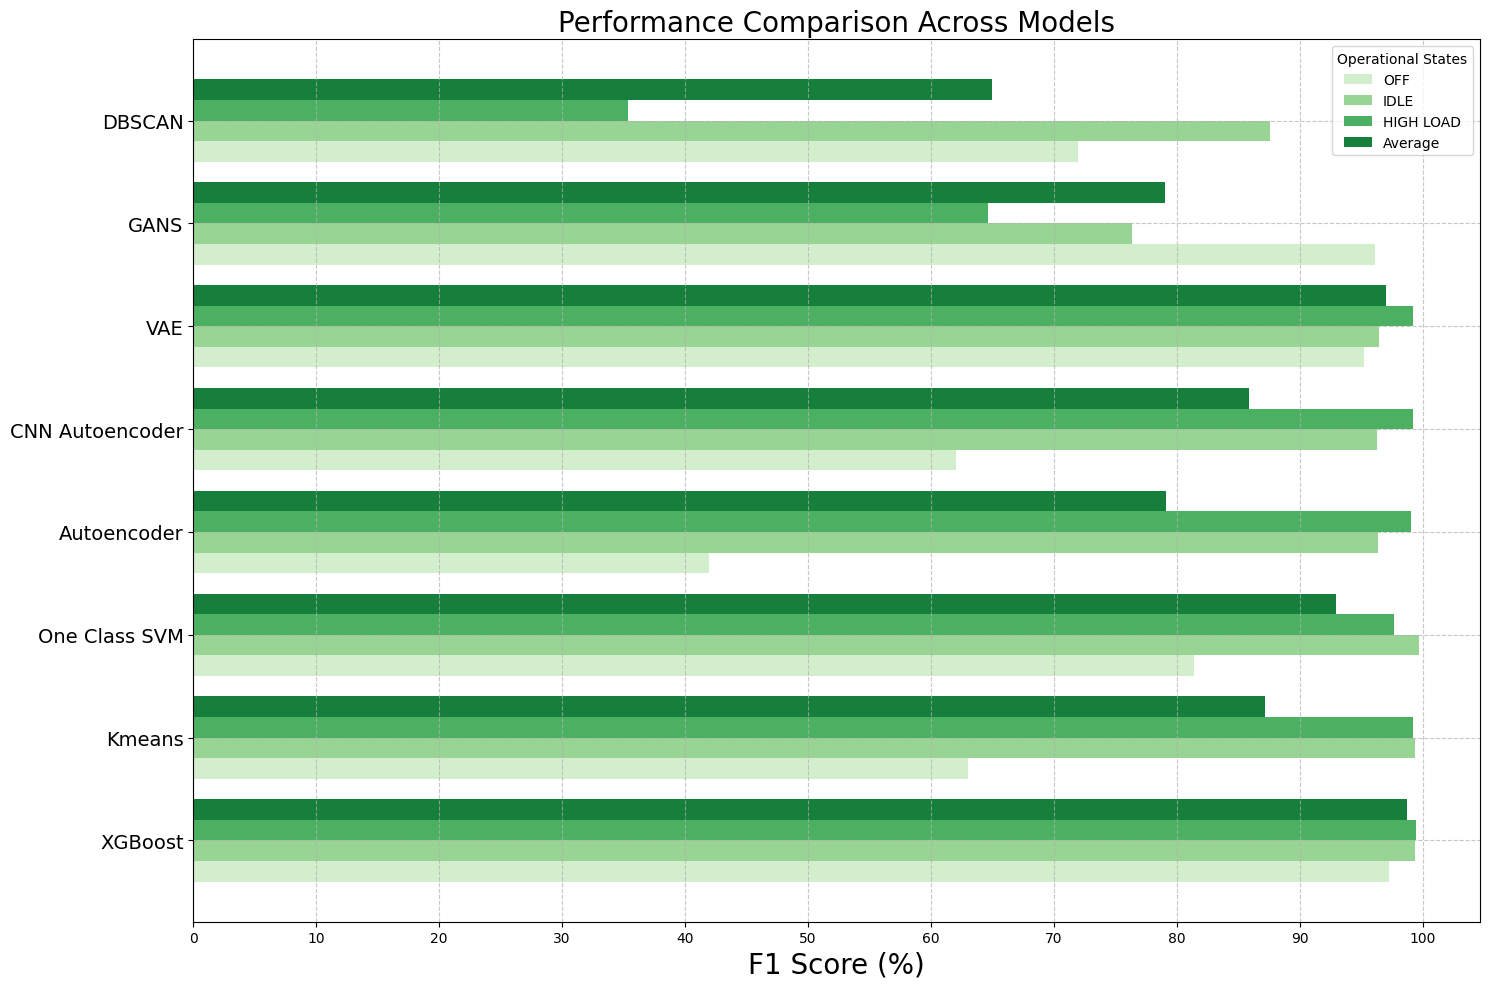

In [60]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Data for all models
data = {
    "Models": ["XGBoost", "Kmeans", "One Class SVM", "Autoencoder", "CNN Autoencoder", "VAE", "GANS", "DBSCAN"],
    "OFF": [97.24, 62.99, 81.37, 41.96, 62, 95.26, 96.14, 72],
    "IDLE": [99.37, 99.37, 99.68, 96.34, 96.26, 96.42, 76.34, 87.62],
    "HIGH LOAD": [99.45, 99.25, 97.7, 99.07, 99.25, 99.25, 64.64, 35.35],
    "Average": [98.69, 87.20, 92.92, 79.12, 85.84, 96.98, 79.04, 64.99]
}
df = pd.DataFrame(data)

plt.figure(figsize=(15, 10))
x = np.arange(len(df['Models']))  # the label locations
width = 0.2  # the width of the bars
colors = plt.cm.Greens(np.linspace(0.2, 0.8, 4))  # Selecting 4 shades of gray from the colormap

# Plot each operational state as a separate bar in the bar plot
for i, column in enumerate(['OFF', 'IDLE', 'HIGH LOAD', 'Average']):
    plt.barh(x + i * width, df[column], width, label=column, color=colors[i])

plt.xlabel('F1 Score (%)', fontsize=20)
plt.title('Performance Comparison Across Models', fontsize=20)
plt.yticks(x + width * 1.5, df['Models'], fontsize=14)
plt.xticks(np.arange(0, 110, 10))
plt.legend(title="Operational States", loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("performance.png")
plt.show()


In [28]:
# Evaluation
true_anomalies = np.array(gt).astype(int).reshape(-1)
print("Shapes - true_anomalies:", true_anomalies.shape, "anomalies:", anomalies.shape)
print(classification_report(true_anomalies, anomalies))


Shapes - true_anomalies: (2880303,) anomalies: (2880303,)


/home/n22sharm/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/n22sharm/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.33      0.99      0.50    963080
           1       0.07      0.00      0.00   1565553
           2       0.00      0.00      0.00    349460
           3       0.00      0.00      0.00      2210

    accuracy                           0.33   2880303
   macro avg       0.10      0.25      0.13   2880303
weighted avg       0.15      0.33      0.17   2880303



/home/n22sharm/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:

directory_path = 'dataset'

# List to store the paths of the relevant files
file_paths = []
file_paths_2 = []


for root, dirs, files in os.walk(directory_path):
    for file in files:
        # Check if the file name contains 'trace' and ends with '.npy'
        if 'trace' in file and file.endswith('.npy'):
            file_paths.append(os.path.join(root, file))
for root, dirs, files in os.walk(directory_path):
    for file in files:
        # Check if the file name contains 'trace' and ends with '.npy'
        if 'gt' in file and file.endswith('.npy'):
            if file in ["gt_0.npy","gt_10.npy","gt_2.npy","gt_3.npy","gt_4.npy","gt_5.npy","gt_6.npy","gt_7.npy","gt_8.npy","gt_9.npy"]:
                file_paths_2.append(os.path.join(root, file))

file_paths.sort()
file_paths_2.sort()

trace = np.array([])
gt = np.array([])

# Load each file and append its data to the combined array
for file_path in file_paths:

    data = np.load(file_path)
    print(f"{file_path} {len(data)}" )
    trace = np.append(trace, data)
    
    
for file_path in file_paths_2:
    
    data = np.load(file_path)
    print(f"{file_path} {len(data)}" )
    gt = np.append(gt, data)
    
  